# RNNs
Playing with RNNs

In [1]:
# If using one or multiple GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import tensorflow as tf
import numpy as np

## Custom RNN cells
I'll first create my own basic RNN cells to test my understanding of how they work.

### Basic RNN cell, naive input
This is a simple RNN cell that simply applies linear transformations to the state and input at time t, adds them together, and applies the `tanh` non-linearity (as depicted in [Chris Olah's blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)):

![image](./rnn/SimpleRNN.png)

In [18]:
class RNN_cell:
    def __init__(self, x, num_hidden, num_output, activation='tanh'):
        # Get input shape
        input_shape = x.get_shape().as_list()
        batch_size = input_shape[0]
        input_size = input_shape[1] # assume flattened
        
        # Set weight matrices
        self.W_xh = tf.Variable(tf.truncated_normal([input_size, num_hidden]), name='W_xh')
        self.W_hh = tf.Variable(tf.truncated_normal([num_hidden, num_hidden]), name='W_hh')
        self.W_hy = tf.Variable(tf.truncated_normal([num_hidden, num_output]), name='W_hy')
        
        # Define hidden state and input
        self.state = tf.placeholder(tf.float32, shape=[batch_size, num_hidden], name='hidden_state')
        self.zero_state = np.zeros([batch_size, num_hidden])
        self.current_state = self.zero_state
        
        # Define computations
        self.x = x
        self.h1 = tf.matmul(self.x, self.W_xh) # input transform
        self.h2 = tf.matmul(self.state, self.W_hh) # hidden transform
        self.s = tf.tanh(tf.add(self.h1, self.h2)) # update state
        self.y = tf.matmul(self.s, self.W_hy)
        
        # tf session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def step(self, x):
        # Compute output and new state
        y, new_state = self.sess.run([self.y, self.s], 
                                     feed_dict={self.state: self.current_state, self.x: x})
        # Update current state
        self.current_state = new_state
        
        return y
    
    def out(self, X):
        self.current_state = self.zero_state
        y = []
        for x_t in X:
            y.append(self.step(x_t))
        
        return y

In [19]:
tf.reset_default_graph()

batch_size = 2
input_size = 4
x = tf.placeholder(tf.float32, shape=[batch_size, input_size])
num_hidden = 3
num_output = 1
rnn = RNN_cell(x, num_hidden, num_output)

In [20]:
for _ in range(5):
    x = [[0, 0, 0, 0], [1, 1, 1, 1]]
    y = rnn.step(x)
    print(y)
    print(rnn.current_state)
    print()

[[ 0.        ]
 [-0.72981167]]
[[ 0.          0.          0.        ]
 [ 0.5832566  -0.2486003   0.43648246]]

[[ 0.        ]
 [ 0.18836218]]
[[ 0.          0.          0.        ]
 [ 0.51001525  0.59857416  0.27309674]]

[[ 0.        ]
 [ 0.30364376]]
[[ 0.          0.          0.        ]
 [-0.24466427  0.20748833 -0.41599485]]

[[ 0.        ]
 [-1.24082625]]
[[ 0.          0.          0.        ]
 [ 0.59718233 -0.70386559  0.4279916 ]]

[[ 0.        ]
 [ 0.13348949]]
[[ 0.          0.          0.        ]
 [ 0.77958661  0.69025028  0.59718585]]



In [21]:
# Time major axis
X = np.ones([5, batch_size, input_size])
X[:, 0, :] = 0
y = rnn.out(X)
[print(y_t) for y_t in y]
print(rnn.current_state)

[[ 0.        ]
 [-0.72981167]]
[[ 0.        ]
 [ 0.18836218]]
[[ 0.        ]
 [ 0.30364376]]
[[ 0.        ]
 [-1.24082625]]
[[ 0.        ]
 [ 0.13348949]]
[[ 0.          0.          0.        ]
 [ 0.77958661  0.69025028  0.59718585]]


### Basic RNN cell, sequential input
Rather than passing inputs from individual time steps with shape `[t, batch_size, ...]` through the RNN multiple times, we can instead pass input that has sequences stacked along the batch dimension, i.e. with shape `[t * batch_size, ...]` of the form $\{x^1_1, ..., x^1_n, x^2_1, ..., x^2_n, x^3_1, ...\}$ and then let the RNN cell take care of reshaping into time sequences.

In [25]:
# Sample parameters
batch_size = 3
trace_length = 2

# shape = [batch_size * trace_length, ...] in form shown above
A = np.ones([batch_size * trace_length, 3, 3])
for i in range(2):
    A[i::2, ...] = i
print("A")
print(A) # each batch contains a 3x3 matrix of zeros followed by 3x3 matrix of ones
print()

# reshape to [batch_size, trace_]
B = np.reshape(A, [3, 2, 3, 3])
for i in range(B.shape[0]):
    print("B[%d]" % i)
    print(B[i, 0]) # should print 3x3 matrix of zeros
    print(B[i, 1]) # should print 3x3 matrix of ones

A
[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]]

B[0]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
B[1]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
B[2]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


In [37]:
class RNN_cell:
    def __init__(self, x, num_hidden, num_output, activation='tanh'): 
        # Get input shape
        input_shape = x.get_shape().as_list()
        batch_size = input_shape[0]
        trace_length = input_shape[1]
        input_size = input_shape[2] # assume flattened
        self.x = tf.placeholder(tf.float32, shape=[batch_size, input_size]) # input placeholder (or input layer)
        
        # Set weight matrices
        self.W_xh = tf.Variable(tf.truncated_normal([input_size, num_hidden]), name='W_xh')
        self.W_hh = tf.Variable(tf.truncated_normal([num_hidden, num_hidden]), name='W_hh')
        self.W_hy = tf.Variable(tf.truncated_normal([num_hidden, num_output]), name='W_hy')
        
        # Define hidden state and input
        self.state = tf.placeholder(tf.float32, shape=[batch_size, num_hidden], name='hidden_state')
        self.zero_state = np.zeros([batch_size, num_hidden])
        self.current_state = self.zero_state
        
        # Set up main computational graph
        self.h1 = tf.matmul(self.x, self.W_xh) # input transform
        self.h2 = tf.matmul(self.state, self.W_hh) # hidden transform
        self.s = tf.tanh(tf.add(self.h1, self.h2)) # update state
        self.y = tf.matmul(self.s, self.W_hy) # output at time t
        
        # tf session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def step(self, x):
        # shape(x) = [batch_size, input_size] at time t
        # Compute output and new state
        y, new_state = self.sess.run([self.y, self.s], 
                                     feed_dict={self.state: self.current_state, self.x: x})
        # Update current state
        self.current_state = new_state
        
        return y
    
    def out(self, X):
        # Reset state to zero state
        self.current_state = self.zero_state
        
        # Pass batch input x_t for each time step t
        y = []
        for i in range(X.shape[1]):
            y.append(self.step(X[:, i, ...]))
        
        return y

In [42]:
# Set up RNN cell
tf.reset_default_graph()
batch_size = 2
trace_length = 5
input_size = 4
x = tf.placeholder(tf.float32, shape=[batch_size, trace_length, input_size])
num_hidden = 3
num_output = 1
rnn = RNN_cell(x, num_hidden, num_output)

# Same test run
x = np.random.random([batch_size, trace_length, input_size]) 
y = rnn.out(x)
print(y)
print(rnn.current_state)

[array([[ 1.11198759],
       [ 0.88573521]], dtype=float32), array([[ 1.48039114],
       [ 1.31830537]], dtype=float32), array([[ 1.42966747],
       [ 1.2085216 ]], dtype=float32), array([[ 1.28310418],
       [ 1.6828239 ]], dtype=float32), array([[ 1.30481863],
       [ 1.18696034]], dtype=float32)]
[[ 0.29764178  0.47977298  0.99106669]
 [ 0.02432045  0.49872658  0.99757266]]


## LSTM cell
Now let's try to build an LSTM cell, following this graphical depiction from [Chris Olah's blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/):

![image](./rnn/LSTM.png)

A small note: we will be concatenating the input and hidden states rather than simply adding them to be consistent with the notation in this post.

In [4]:
class LSTM_cell:
    def __init__(self, x, num_hidden, activation='tanh'): 
        # Get input shape
        input_shape = x.get_shape().as_list()
        batch_size = input_shape[0]
        trace_length = input_shape[1]
        input_size = input_shape[2] # assume flattened
        self.x = tf.placeholder(tf.float32, 
                                shape=[batch_size, input_size],
                                name='x_t') # input placeholder (or input layer)
        
        # Zero state
        self.zero_state = np.zeros([batch_size, num_hidden])

        # Cell state
        self.cell_state = tf.placeholder(tf.float32,
                                         shape=[batch_size, num_hidden],
                                         name='cell_state')
        self.current_cell_state = self.zero_state

        # Hidden state
        self.hidden_state = tf.placeholder(tf.float32, 
                                           shape=[batch_size, num_hidden], 
                                           name='hidden_state')
        self.current_hidden_state = self.zero_state

        # Forget gate
        with tf.name_scope("forget_gate"):
            self.W_f = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_f')
            self.b_f = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_f")
            self.f_t = tf.matmul(tf.concat([self.hidden_state, self.x], 1), self.W_f) + self.b_f
            self.f_t = tf.sigmoid(self.f_t, name='f_t')
        
        # Input gate
        with tf.name_scope("input_gate"):
            self.W_i = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_i')
            self.b_i = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_i")
            self.i_t = tf.matmul(tf.concat([self.hidden_state, self.x], 1), self.W_i) + self.b_i
            self.i_t = tf.sigmoid(self.i_t, name='i_t')
        
        
        # New cell state candidate values
        with tf.name_scope("candidate_values"):
            self.W_c = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_c')
            self.b_c = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_c")
            self.c_t_ = tf.matmul(tf.concat([self.hidden_state, self.x], 1), self.W_c) + self.b_c
            self.c_t_ = tf.tanh(self.c_t_, name='c_t_')
        
        # Combine forget and input gates to update cell state
        with tf.name_scope("update_cell_state"):
            self.c_t_f = tf.multiply(self.cell_state, self.f_t, name='c_t_f') 
            self.c_t_i = tf.multiply(self.c_t_, self.i_t, name='c_t_i') 
            self.c_t = tf.add(self.c_t_f, self.c_t_i, name='c_t')
        
        # Output gate
        with tf.name_scope("output_gate"):
            self.W_o = tf.Variable(tf.truncated_normal([num_hidden +  input_size, num_hidden]),
                                   name='W_o')
            self.b_o = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name='b_o')
            self.o_t = tf.matmul(tf.concat([self.hidden_state, self.x], 1), self.W_o) + self.b_o
            self.o_t = tf.sigmoid(self.o_t, name='o_t')
        
        # Gate tanh(cell state) with output gate to update hidden state (output)
        with tf.name_scope("update_hidden_state"):
            self.h_t = tf.multiply(tf.tanh(self.c_t), self.o_t, name='h_t')
        
        # tf session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def step(self, x):
        # shape(x) = [batch_size, input_size] at time t
        # Compute output and new state
        h, c = self.sess.run([self.h_t, self.c_t], 
                             feed_dict={self.x: x,
                                        self.hidden_state: self.current_hidden_state, 
                                        self.cell_state: self.current_cell_state})
        # Update current states
        self.current_hidden_state = h
        self.current_cell_state = c
        
        return h
    
    def out(self, X):
        # Reset state to zero state
        self.current_hidden_state = self.zero_state
        self.current_cell_state = self.zero_state
        
        # Pass batch input x_t for each time step t
        H = []
        for i in range(X.shape[1]):
            H.append(self.step(X[:, i, ...]))
        
        return H

In [6]:
# Set up RNN cell
tf.reset_default_graph()
batch_size = 2
trace_length = 5
input_size = 4
x = tf.placeholder(tf.float32, shape=[batch_size, trace_length, input_size])
num_hidden = 3
rnn = LSTM_cell(x, num_hidden)

# Same test run
x = np.random.random([batch_size, trace_length, input_size]) 
h = rnn.out(x)
print("hidden states:")
for h_t in h: print(h_t)
print("\ncurrent hidden state:")
print(rnn.current_hidden_state)
print("\ncurrent cell state:")
print(rnn.current_cell_state)

hidden states:
[[ 0.36249086  0.03932692  0.03911257]
 [ 0.20759627  0.2687242  -0.01895547]]
[[ 0.10290282 -0.02434576 -0.03873252]
 [ 0.14209694  0.2538662  -0.0651268 ]]
[[ 0.23239931 -0.05251402  0.01512763]
 [ 0.23350267  0.22753493 -0.03943847]]
[[ 0.17305562 -0.07541554 -0.06053226]
 [ 0.33283624  0.10467365  0.08489635]]
[[ 0.39625847  0.02193981  0.01964775]
 [ 0.18227693  0.02154228  0.03121651]]

current hidden state:
[[ 0.39625847  0.02193981  0.01964775]
 [ 0.18227693  0.02154228  0.03121651]]

current cell state:
[[ 0.51729691  0.02303421  0.05977021]
 [ 0.26779944  0.02440291  0.07869279]]


### Visualizing tf graph
Note: this may only work in Chrome.

In [12]:
# Credit: https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [8]:
show_graph(tf.get_default_graph().as_graph_def())

### Unrolling the network
The graph above looks good, but instead of iterating through a `for` loop to compute each time step, let's unroll the network to compute the output at all time steps at once.

In [17]:
class LSTM_layer: 
    def __init__(self, x, num_hidden, activation='tanh'):
        # Get input shape
        input_shape = x.get_shape().as_list()
        self.batch_size = input_shape[0]
        trace_length = input_shape[1]
        self.input_size = input_shape[2] # assume flattened
        self.x = x
        x_series = tf.unstack(x, axis=1)
        
        # Zero state
        self.zero_state = np.zeros([batch_size, num_hidden])
        self.init_hidden_state = tf.placeholder(tf.float32,
                                                shape=[batch_size, num_hidden],
                                                name='init_hidden_state')
        self.init_cell_state = tf.placeholder(tf.float32,
                                              shape=[batch_size, num_hidden],
                                              name='init_cell_state')
        
        # Create shared parameters
        with tf.name_scope("params"):
            self.W_f = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_f')
            self.b_f = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_f")
            self.W_i = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_i')
            self.b_i = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_i")
            self.W_c = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_c')
            self.b_c = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_c")
            self.W_o = tf.Variable(tf.truncated_normal([num_hidden +  input_size, num_hidden]),
                                   name='W_o')
            self.b_o = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name='b_o')
        
        # Unroll network by creating (trace_length) LSTM cells
        h_t = self.init_hidden_state
        c_t = self.init_cell_state
        self.outputs = []
        for t, x_t in enumerate(x_series):
            h_t, c_t = self.LSTM_cell(x_t, h_t, c_t, scope="Cell_%d" % t)
            self.outputs.append(h_t)
        
        # tf session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def LSTM_cell(self, x_t, hidden_state, cell_state, scope="Cell"):
        with tf.name_scope(scope):
            # Forget gate
            with tf.name_scope("forget_gate"):
                W_f = self.W_f # vs. tf.identity(self.W_f)
                b_f = self.b_f # vs. tf.identity(self.b_f)
                f_t = tf.matmul(tf.concat([hidden_state, x_t], 1), W_f) + b_f
                f_t = tf.sigmoid(f_t, name='f_t')

            # Input gate
            with tf.name_scope("input_gate"):
                W_i = self.W_i
                b_i = self.b_i
                i_t = tf.matmul(tf.concat([hidden_state, x_t], 1), W_i) + b_i
                i_t = tf.sigmoid(i_t, name='i_t')


            # New cell state candidate values
            with tf.name_scope("candidate_values"):
                W_c = self.W_c
                b_c = self.b_c
                c_t_ = tf.matmul(tf.concat([hidden_state, x_t], 1), W_c) + b_c
                c_t_ = tf.tanh(c_t_, name='c_t_')

            # Combine forget and input gates to update cell state
            with tf.name_scope("update_cell_state"):
                c_t_f = tf.multiply(cell_state, f_t, name='c_t_f') 
                c_t_i = tf.multiply(c_t_, i_t, name='c_t_i') 
                c_t = tf.add(c_t_f, c_t_i, name='c_t')

            # Output gate
            with tf.name_scope("output_gate"):
                W_o = self.W_o
                b_o = self.b_o
                o_t = tf.matmul(tf.concat([hidden_state, x_t], 1), W_o) + b_o
                o_t = tf.sigmoid(o_t, name='o_t')

            # Gate tanh(cell state) with output gate to update hidden state (output)
            with tf.name_scope("update_hidden_state"):
                h_t = tf.multiply(tf.tanh(c_t), o_t, name='h_t')

            return h_t, c_t
    
    def out(self, X):
        feed_dict = {self.x: X,
                     self.init_hidden_state: self.zero_state,
                     self.init_cell_state: self.zero_state}
        return self.sess.run(self.outputs, feed_dict=feed_dict)

In [18]:
# Set up RNN cell
tf.reset_default_graph()
batch_size = 2
trace_length = 5
input_size = 4
x = tf.placeholder(tf.float32, 
                   shape=[batch_size, trace_length, input_size],
                   name='input_series')
num_hidden = 3
rnn = LSTM_layer(x, num_hidden)

# Same test run
x = np.random.random([batch_size, trace_length, input_size]) 
h = rnn.out(x)
print("hidden states:")
for h_t in h: print(h_t)

hidden states:
[[-0.07845152 -0.0468897  -0.12943874]
 [ 0.02393308  0.01062461  0.01333745]]
[[-0.18784374 -0.04632721 -0.15332571]
 [ 0.13834111 -0.04746186 -0.08977975]]
[[-0.30638924 -0.14702731 -0.2577512 ]
 [ 0.10506167 -0.11854228 -0.17134102]]
[[-0.38088018 -0.01861375 -0.27257231]
 [ 0.19053105 -0.08923865 -0.26499707]]
[[-0.40826714  0.09289505 -0.21621533]
 [ 0.17739724 -0.09497022 -0.2219989 ]]


In [19]:
show_graph(tf.get_default_graph().as_graph_def())

### Implementing backprop
The previous networks were only defined for the forward passes. In order to train them, we need to implement some form of backpropagation through time (BPTT). Rather than backpropagating entire sequences, which can be thousands to tens of thousands steps, backpropagation is often "cut off" after some specified length in a process termed "truncated backpropagation". Say you have a sequence of length $n$ with a truncated backpropagation length of $m$. Every $k_1$ timesteps, truncated backprogation performs BPTT for $k_2$ timesteps. There are two basic approaches:

1) Set $k_1=k_2$. That is, if BPTT is truncated to 10 timesteps backward, then BPTT is only performed every 10 timesteps. In other words, for a sequence $\{x_1, \ldots, x_n\}$, the network learns from sequences $\{x_1, \ldots, x_m\}, \{x_{m+1}, \ldots, x_{2m}\}, \ldots, \{x_{n-m}, \ldots, x_n\}$. This is the approach that TensorFlow uses.

2) Set $k_1=1$. That is, perform BPTT every timestep, regardless of BPTT length. In other words, for a sequence $\{x_1, \ldots, x_n\}$, the network learns from sequences $\{x_1, \ldots, x_m\}, \{x_2, \ldots, x_{m+1}\}, \ldots, \{x_{n-m}, \ldots, x_n\}$.



In [4]:
# Let's define the class to build the graph, not perform computations
class LSTM_layer: 
    def __init__(self, x, num_hidden, activation='tanh'):
        # Get input shape
        input_shape = x.get_shape().as_list()
        self.batch_size = input_shape[0]
        trace_length = input_shape[1]
        self.input_size = input_shape[2] # assume flattened
        x_series = tf.unstack(x, axis=1)
        
        # Initial states
        self.init_hidden_state = tf.placeholder(tf.float32,
                                                shape=[batch_size, num_hidden],
                                                name='init_hidden_state')
        self.init_cell_state = tf.placeholder(tf.float32,
                                              shape=[batch_size, num_hidden],
                                              name='init_cell_state')
        
        # Create shared parameters
        with tf.name_scope("params"):
            self.W_f = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_f')
            self.b_f = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_f")
            self.W_i = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_i')
            self.b_i = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_i")
            self.W_c = tf.Variable(tf.truncated_normal([num_hidden + input_size, num_hidden]),
                                   name='W_c')
            self.b_c = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name="b_c")
            self.W_o = tf.Variable(tf.truncated_normal([num_hidden +  input_size, num_hidden]),
                                   name='W_o')
            self.b_o = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_hidden]),
                                   name='b_o')
        
        # Unroll network by creating (trace_length) LSTM cells
        h_t = self.init_hidden_state
        c_t = self.init_cell_state
        self.hidden_states = []
        self.cell_states = []
        for t, x_t in enumerate(x_series):
            h_t, c_t = self.LSTM_cell(x_t, h_t, c_t, scope="Cell_%d" % t)
            self.hidden_states.append(h_t)
            self.cell_states.append(c_t)
        
    def LSTM_cell(self, x_t, hidden_state, cell_state, scope="Cell"):
        with tf.name_scope(scope):
            # Forget gate
            with tf.name_scope("forget_gate"):
                W_f = self.W_f # vs. tf.identity(self.W_f)
                b_f = self.b_f # vs. tf.identity(self.b_f)
                f_t = tf.matmul(tf.concat([hidden_state, x_t], 1), W_f) + b_f
                f_t = tf.sigmoid(f_t, name='f_t')

            # Input gate
            with tf.name_scope("input_gate"):
                W_i = self.W_i
                b_i = self.b_i
                i_t = tf.matmul(tf.concat([hidden_state, x_t], 1), W_i) + b_i
                i_t = tf.sigmoid(i_t, name='i_t')


            # New cell state candidate values
            with tf.name_scope("candidate_values"):
                W_c = self.W_c
                b_c = self.b_c
                c_t_ = tf.matmul(tf.concat([hidden_state, x_t], 1), W_c) + b_c
                c_t_ = tf.tanh(c_t_, name='c_t_')

            # Combine forget and input gates to update cell state
            with tf.name_scope("update_cell_state"):
                c_t_f = tf.multiply(cell_state, f_t, name='c_t_f') 
                c_t_i = tf.multiply(c_t_, i_t, name='c_t_i') 
                c_t = tf.add(c_t_f, c_t_i, name='c_t')

            # Output gate
            with tf.name_scope("output_gate"):
                W_o = self.W_o
                b_o = self.b_o
                o_t = tf.matmul(tf.concat([hidden_state, x_t], 1), W_o) + b_o
                o_t = tf.sigmoid(o_t, name='o_t')

            # Gate tanh(cell state) with output gate to update hidden state (output)
            with tf.name_scope("update_hidden_state"):
                h_t = tf.multiply(tf.tanh(c_t), o_t, name='h_t')

            return h_t, c_t

In [55]:
# Set up input
tf.reset_default_graph()
batch_size = 1
trace_length = 3
input_size = 4
x = tf.placeholder(tf.float32, 
                   shape=[batch_size, trace_length, input_size],
                   name='input_series')

# Add RNN cell
num_hidden = 3
rnn = LSTM_layer(x, num_hidden)

# Add simple softmax output layer
preds = []
num_output = 2
W_p = tf.Variable(tf.truncated_normal([num_hidden, num_output]), name='W_p')
b_p = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_output]), name='b_p')
with tf.name_scope("preds"):
    for h_t in rnn.hidden_states:
        preds.append(tf.nn.softmax(tf.matmul(h_t, W_p) + b_p))

# Add loss function
y = tf.placeholder(tf.float32, shape=[batch_size, trace_length, num_output], 
                         name='y')
y_series = tf.unstack(y, axis=1)
losses = []
with tf.name_scope("losses"):
    for i, [pred_t, y_t] in enumerate(zip(preds, y_series)):
        with tf.name_scope("loss_%d" % i):
            losses.append(tf.reduce_sum(-y_t * tf.log(pred_t)))
    total_loss = tf.reduce_mean(losses, name='total_loss')

# Add optimizer
optimizer = tf.train.RMSPropOptimizer(0.1)
train_step = optimizer.minimize(total_loss)
    
# Grab gradients for interest
    
    
# Add session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Sample backpropagation step
x_batch = np.random.random([batch_size, trace_length, input_size])
y_batch = np.random.random([batch_size, trace_length, num_output])
y_batch[:, :, 1] = 1 - y_batch[:, :, 0]
y_batch = (y_batch > 0.5).astype(int) # creates one-hot vectors
zero_state = np.zeros([batch_size, num_hidden])
feed_dict = {x: x_batch,
             rnn.init_hidden_state: zero_state,
             rnn.init_cell_state: zero_state,
             y: y_batch}
preds_batch, losses_batch, _ = sess.run([preds, losses, train_step], 
                                        feed_dict=feed_dict)
print("preds:")
for p in preds_batch: print(p)

print("labels:")
for y_t in y_batch: print(y_t)
    
print("losses:")
for l in losses_batch: print(l)

preds:
[[ 0.54066342  0.45933658]]
[[ 0.53943419  0.46056589]]
[[ 0.54027724  0.4597227 ]]
labels:
[[0 1]
 [0 1]
 [1 0]]
losses:
0.777972
0.775299
0.615673


Let's verify the gradients that TensorFlow is calculating.

In [ ]:
# Try when you dare


Now let's try it on some toy data set. Let's use the Echo-RNN set from [this blog post](https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767). 

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(loss_list, predictions_series, batchX, batchY, truncated_backprop_length):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

In [37]:
# Hyperparameters
num_epochs = 500
total_series_length = 50000
trace_length = 15
input_size = 1
num_hidden = 4
num_classes = 2
echo_step = 3
batch_size = 5

# Set up input
tf.reset_default_graph()
x = tf.placeholder(tf.float32, 
                   shape=[batch_size, trace_length, input_size],
                   name='input_series')

# Add RNN cell
num_hidden = 3
rnn = LSTM_layer(x, num_hidden)

# Add simple softmax output layer
preds = []
W_p = tf.Variable(tf.truncated_normal([num_hidden, num_classes]), name='W_p')
b_p = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[1, num_classes]), name='b_p')
with tf.name_scope("preds"):
    for h_t in rnn.hidden_states:
        preds.append(tf.nn.softmax(tf.matmul(h_t, W_p) + b_p))

# Add loss function
y = tf.placeholder(tf.int32, shape=[batch_size, trace_length], 
                         name='y')
labels = tf.one_hot(y, 2)
labels_series = tf.unstack(labels, axis=1)
losses = []
with tf.name_scope("losses"):
    for i, [pred_t, y_t] in enumerate(zip(preds, labels_series)):
        with tf.name_scope("loss_%d" % i):
            losses.append(tf.reduce_sum(-y_t * tf.log(pred_t)))
    total_loss = tf.reduce_mean(losses, name='total_loss')

# Add optimizer
optimizer = tf.train.AdagradOptimizer(0.3)
train_step = optimizer.minimize(total_loss)
    
# Grab gradients for interest
    
    
# Add session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
# Training
loss_list = []
for epoch in range(num_epochs):
    # Generate data
    den = batch_size * trace_length # total data length must be multiple
    x_length = total_series_length // den * den
    x_batch = np.array(np.random.choice(2, x_length, p=[0.5, 0.5]))
    y_batch = np.roll(x_batch, echo_step)
    y_batch[0:echo_step] = 0
    x_batch = np.reshape(x_batch, [batch_size, -1, trace_length, 1])
    y_batch = np.reshape(y_batch, [batch_size, -1, trace_length])
    num_batches = x_batch.shape[0]
    
    # Set initial RNN states
    current_hidden_state = np.zeros([batch_size, num_hidden])
    current_cell_state = np.zeros([batch_size, num_hidden])
    
    for batch_idx in range(num_batches):
        # Train step
        feed_dict = {x: x_batch[:, batch_idx],
                     rnn.init_hidden_state: current_hidden_state,
                     rnn.init_cell_state: current_cell_state,
                     y: y_batch[:, batch_idx]}
        current_hidden_state, current_cell_state, total_loss_, _ = \
            sess.run([rnn.hidden_states[-1], rnn.cell_states[-1], total_loss, train_step], 
                                  feed_dict=feed_dict)
        loss_list.append(total_loss_)
        
    # Print progress
    print("Epoch %d loss: %.2f" % (epoch+1, total_loss_))

Epoch 1 loss: 3.45
Epoch 2 loss: 3.46
Epoch 3 loss: 3.32
Epoch 4 loss: 3.18
Epoch 5 loss: 2.83
Epoch 6 loss: 2.73
Epoch 7 loss: 2.87
Epoch 8 loss: 2.82
Epoch 9 loss: 2.78
Epoch 10 loss: 2.46
Epoch 11 loss: 2.17
Epoch 12 loss: 2.78
Epoch 13 loss: 2.34
Epoch 14 loss: 2.21
Epoch 15 loss: 2.78
Epoch 16 loss: 1.68
Epoch 17 loss: 1.74
Epoch 18 loss: 2.27
Epoch 19 loss: 1.49
Epoch 20 loss: 1.97
Epoch 21 loss: 1.61
Epoch 22 loss: 1.55
Epoch 23 loss: 1.78
Epoch 24 loss: 2.04
Epoch 25 loss: 1.23
Epoch 26 loss: 1.28
Epoch 27 loss: 1.68
Epoch 28 loss: 1.28
Epoch 29 loss: 1.17
Epoch 30 loss: 1.53
Epoch 31 loss: 1.97
Epoch 32 loss: 2.34
Epoch 33 loss: 1.00
Epoch 34 loss: 1.07
Epoch 35 loss: 1.06
Epoch 36 loss: 1.86
Epoch 37 loss: 1.50
Epoch 38 loss: 1.08
Epoch 39 loss: 1.58
Epoch 40 loss: 1.27
Epoch 41 loss: 0.93
Epoch 42 loss: 1.00
Epoch 43 loss: 1.32
Epoch 44 loss: 1.16
Epoch 45 loss: 1.05
Epoch 46 loss: 1.88
Epoch 47 loss: 1.12
Epoch 48 loss: 1.26
Epoch 49 loss: 2.25
Epoch 50 loss: 1.28
Epoch 51 

Epoch 399 loss: 0.01
Epoch 400 loss: 0.01
Epoch 401 loss: 0.01
Epoch 402 loss: 0.01
Epoch 403 loss: 0.01
Epoch 404 loss: 0.01
Epoch 405 loss: 0.02
Epoch 406 loss: 0.01
Epoch 407 loss: 0.02
Epoch 408 loss: 0.01
Epoch 409 loss: 0.01
Epoch 410 loss: 0.01
Epoch 411 loss: 0.01
Epoch 412 loss: 0.01
Epoch 413 loss: 0.01
Epoch 414 loss: 0.01
Epoch 415 loss: 0.02
Epoch 416 loss: 0.02
Epoch 417 loss: 0.02
Epoch 418 loss: 0.01
Epoch 419 loss: 0.01
Epoch 420 loss: 0.02
Epoch 421 loss: 0.02
Epoch 422 loss: 0.01
Epoch 423 loss: 0.01
Epoch 424 loss: 0.01
Epoch 425 loss: 0.03
Epoch 426 loss: 0.01
Epoch 427 loss: 0.01
Epoch 428 loss: 0.01
Epoch 429 loss: 0.01
Epoch 430 loss: 0.01
Epoch 431 loss: 0.01
Epoch 432 loss: 0.01
Epoch 433 loss: 0.01
Epoch 434 loss: 0.02
Epoch 435 loss: 0.01
Epoch 436 loss: 0.01
Epoch 437 loss: 0.02
Epoch 438 loss: 0.02
Epoch 439 loss: 0.01
Epoch 440 loss: 0.01
Epoch 441 loss: 0.02
Epoch 442 loss: 0.02
Epoch 443 loss: 0.01
Epoch 444 loss: 0.01
Epoch 445 loss: 0.01
Epoch 446 los

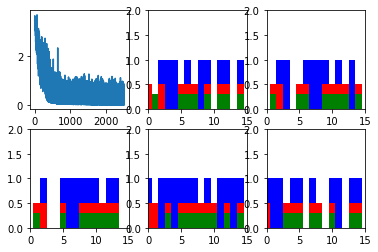

In [39]:
feed_dict = {x: x_batch[:, -2],
             rnn.init_hidden_state: init_hidden_state,
             rnn.init_cell_state: init_cell_state,
             y: y_batch[:, -2]}
preds_ = sess.run(preds, feed_dict=feed_dict)
plot(loss_list, preds_, x_batch[:, -2], y_batch[:, -2], trace_length)

## Reshaping for DRQN agent
Since the DRQN agent will be riding the DQN n-step and trajectory replay functions, we need to be sure that we are reshaping sample memories in the right order.

In [42]:
total_size = 50
sample_size = 5
tr_len = 3
n_step = 2
idx = np.random.randint(0, total_size, sample_size)
print(idx)
x, y = np.meshgrid(idx, np.arange(tr_len) * n_step) # non-overlapping n-step sequences
idx = np.transpose(x + y).flatten() # [i, i+1, ..., i+n, j, j+1, ..., j+n, k...]
print(idx)
print(idx.reshape(sample_size, tr_len))

[38 12 11 23 42]
[38 40 42 12 14 16 11 13 15 23 25 27 42 44 46]
[[38 40 42]
 [12 14 16]
 [11 13 15]
 [23 25 27]
 [42 44 46]]


## Testing DRQN implementation

In [1]:
# If using one or multiple GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
import os
os.chdir("../python")

In [3]:
import tensorflow as tf
import numpy as np
from vizdoom import *
from network.DRQNetwork import DRQNetwork
from helper import create_network, create_agent

In [4]:
tf.reset_default_graph()

net_file = "../networks/drqn.json"
phi = 1
channels = 1
num_actions = 4
alpha = 0.01
params_file = None
output_dir = "../notebooks/rnn/test/" 
sess = tf.Session()
train_mode = True

net = create_network(net_file,
                     phi=phi, 
                     num_channels=channels, 
                     num_outputs=num_actions,
                     learning_rate=alpha,
                     params_file=params_file,
                     output_directory=output_dir,
                     session=sess,
                     train_mode=train_mode,
                     scope="")

In [6]:
tf.reset_default_graph()

agent_file_path = "../notebooks/rnn/drqn.json"
config_file_path = "../config/open_field.cfg"
params_file_path = None
action_set = "basic_three"
results_dir = "../notebooks/rnn/test/"

game = DoomGame()
game.load_config(config_file_path)
game.init()

agent = create_agent(agent_file_path,
                     game=game, 
                     params_file=params_file_path,
                     action_set=action_set,
                     output_directory=results_dir)

Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 84, 84, 3), dtype=float32)
[GameVariable.HEALTH] --> Tensor("main_network/health:0", shape=(?, 1), dtype=float32)
[GameVariable.VELOCITY_X, GameVariable.VELOCITY_Y] --> Tensor("main_network/velocity:0", shape=(?, 2), dtype=float32)


In [7]:
agent.initialize_new_episode()

In [9]:
for _ in range(50):
    agent.perform_learning_step(1, 10)

In [30]:
s1, a, s2, isterminal, r, w, idx = agent.memory.get_sample(agent.batch_size)
target_q = agent._get_target_q(s1, a, s2, isterminal, r)
s1 = agent.network._check_state(s1)
a = agent.network._check_actions(a)
a = a[::32]
target_q = target_q[::32]
w = w[::32]
feed_dict = {s_: s for s_, s in zip(agent.network.state, s1)} 
feed_dict.update({agent.network.actions: a, 
                  agent.network.target_q: target_q, 
                  agent.network.IS_weights: w})
feed_dict = agent.network._check_train_mode(feed_dict)
print(w.shape, a.shape, target_q.shape, s1[0].shape)
#lstm = tf.get_default_graph().get_tensor_by_name("main_network/LSTM_1/rnn/transpose:0")
q_sa = tf.get_default_graph().get_tensor_by_name("main_network/loss/q_sa:0")
out, out2 = agent.network.sess.run([agent.network.q, q_sa], feed_dict=feed_dict)
print(out.shape, out2.shape)
print(out[::32, :])
print(out2)

(10,) (10, 2) (10,) (320, 84, 84, 3)
(320, 3) (10,)
[[-0.10492384  0.39012218 -0.34917536]
 [-0.21287759  0.31767994 -0.44692278]
 [-0.1867802   0.35419792 -0.4402622 ]
 [-0.14460289  0.39855003 -0.42988038]
 [-0.23564385  0.29714859 -0.45321113]
 [-0.1461082   0.34052545 -0.36988449]
 [-0.23667099  0.29579222 -0.44848144]
 [-0.22927527  0.2997233  -0.45408291]
 [-0.23118626  0.29701585 -0.4542383 ]
 [-0.22660463  0.29857078 -0.45613205]]
[-0.10492384 -0.21287759 -0.4402622  -0.42988038 -0.23564385  0.34052545
 -0.23667099 -0.22927527 -0.4542383  -0.45613205]


I was confused why feeding in different lengths for target Q and state did not result in an error. Turns out that the tf op `gather_nd` automatically handles this case by selecting every $n^{th}$ example to make the shapes match along this dimension.

### Loss masking
Routine testing for masking the first $n$ losses during RNN traces.

In [64]:
tf.reset_default_graph()

batch_size = tf.placeholder(tf.int32, shape=[], name="batch_size")
w = tf.placeholder(tf.float32, shape=[None], name="IS_weights")
mask_len = -1
tot_len = tf.shape(w)[0]
tr_len = tot_len // batch_size
mask_len = tf.minimum(mask_len, tr_len)
mask_zeros = tf.zeros([batch_size, mask_len])
mask_ones = tf.ones([batch_size, tr_len - mask_len])
w_ = tf.reshape(tf.concat([mask_zeros, mask_ones], axis=1), [-1])

In [65]:
sess = tf.Session()
feed_dict = {batch_size: 4,
             w: np.random.rand(20)}
print(sess.run(w_, feed_dict=feed_dict))

InvalidArgumentError: Dimension -1 must be >= 0
	 [[Node: zeros = Fill[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](zeros/shape, zeros/Const)]]

Caused by op 'zeros', defined at:
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-0d88ba3453bd>", line 9, in <module>
    mask_zeros = tf.zeros([batch_size, mask_len])
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1360, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1166, in fill
    result = _op_def_lib.apply_op("Fill", dims=dims, value=value, name=name)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Dimension -1 must be >= 0
	 [[Node: zeros = Fill[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](zeros/shape, zeros/Const)]]


### Updating RNN state

In [4]:
tf.reset_default_graph()

agent_file_path = "../notebooks/rnn/drqn.json"
config_file_path = "../config/open_field.cfg"
params_file_path = None
action_set = "basic_three"
results_dir = "../notebooks/rnn/test/"

game = DoomGame()
game.load_config(config_file_path)
game.init()

agent = create_agent(agent_file_path,
                     game=game, 
                     params_file=params_file_path,
                     action_set=action_set,
                     output_directory=results_dir)

Mapping of agent states --> network states:
screen --> Tensor("main_network/screen:0", shape=(?, 84, 84, 3), dtype=float32)


/home/james/DRL/myvizdoom/python/agent/Agent.py:170: UserWarning: The following game variables were not used: 
  warnings.warn(msg)


The issue has now been fixed, so the output displayed below demonstrates the correct cell update. Previously, the last two cells would have been the same.

In [5]:
agent.network.reset_rnn_state()
s1 = [np.ones([1] + agent.network.input_shape), np.zeros(agent.num_game_var)]

for _ in range(3):
    for s in agent.network.rnn_current_states[0][0]:
        print(s[:10])
    agent.network.update_rnn_state(s1)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.10721724 -0.01644403 -0.13550684  0.01726984 -0.03495932  0.0373818
 -0.11352646  0.02683512  0.0235149  -0.04382068]
[-0.17859283 -0.0242555  -0.2544525   0.0274361  -0.07349882  0.06319889
 -0.21599317  0.04630607  0.03474696 -0.06407228]


In [6]:
agent.network.reset_rnn_state()
s1 = [np.ones([1] + agent.network.input_shape), np.zeros(agent.num_game_var)]

for _ in range(3):
    for s in agent.network.rnn_current_states[0][0]:
        print(s[:10])
    
    # Add extra line to update_rnn_state(s1)
    s1_ = agent.network._check_state(s1)
    feed_dict = {s_: s for s_, s in zip(agent.network.state, s1_)}
    feed_dict.update({agent.network.batch_size: 1})
    feed_dict.update({s_: s for s_, s in zip(agent.network.rnn_init_states, agent.network.rnn_current_states)}) # extra line
    agent.network.rnn_current_states = agent.network.sess.run(agent.network.rnn_states, 
                                                    feed_dict=feed_dict)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.10721724 -0.01644403 -0.13550684  0.01726984 -0.03495932  0.0373818
 -0.11352646  0.02683512  0.0235149  -0.04382068]
[-0.17859283 -0.0242555  -0.2544525   0.0274361  -0.07349882  0.06319889
 -0.21599317  0.04630607  0.03474696 -0.06407228]


In [7]:
s1_ = agent.network._check_state(s1)
feed_dict = {s_: s for s_, s in zip(agent.network.state, s1_)}
feed_dict.update({agent.network.batch_size: 1})
#feed_dict.update({s_: s for s_, s in zip(agent.network.rnn_init_states, agent.network.rnn_current_states)}) # extra line
agent.network.rnn_current_states = agent.network.sess.run(agent.network.rnn_states, 
                                                    feed_dict=feed_dict)
for s in agent.network.rnn_current_states[0][0]:
    print(s[:10])

[-0.10721724 -0.01644403 -0.13550684  0.01726984 -0.03495932  0.0373818
 -0.11352646  0.02683512  0.0235149  -0.04382068]


Let's be sure that the `get_rnn_zero_states` is not being mutated by `rnn_current_states` due to passing by reference.

In [10]:
print("current states:")
for s in agent.network.rnn_current_states[0][0]:
    print(s[:10])

print("zero states:")
for s in agent.network.get_rnn_zero_state()[0][0]:
    print(s[:10])

current states:
[-0.10721724 -0.01644403 -0.13550684  0.01726984 -0.03495932  0.0373818
 -0.11352646  0.02683512  0.0235149  -0.04382068]
zero states:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:
print(agent.network.rnn_init_states)

[LSTMStateTuple(c=<tf.Tensor 'main_network/LSTM_1/LSTMCellZeroState/zeros:0' shape=(?, 128) dtype=float32>, h=<tf.Tensor 'main_network/LSTM_1/LSTMCellZeroState/zeros_1:0' shape=(?, 128) dtype=float32>)]


In [11]:
agent.network.reset_rnn_state()
s1 = [np.zeros([1] + agent.network.input_shape), np.zeros(agent.num_game_var)]

for _ in range(3):
    for s in agent.network.rnn_current_states[0][0]:
        print(s[:10])
    
    # Add extra line to update_rnn_state(s1)
    s1_ = agent.network._check_state(s1)
    feed_dict = {s_: s for s_, s in zip(agent.network.state, s1_)}
    feed_dict.update({agent.network.batch_size: 1})
    feed_dict.update({s_: s for s_, s in zip(agent.network.rnn_init_states, agent.network.rnn_current_states)}) # extra line
    agent.network.rnn_current_states = agent.network.sess.run(agent.network.rnn_states, 
                                                    feed_dict=feed_dict)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.10171492 -0.01094173 -0.13184489  0.01610954 -0.03992078  0.03366337
 -0.111006    0.01599175  0.0190571  -0.03910401]
[-0.16979404 -0.01485812 -0.24806482  0.02496561 -0.08228803  0.05632716
 -0.21108341  0.02814458  0.0284702  -0.05713952]
